In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
BASE_PATH = "/content/data"
XML_PATH = os.path.join(BASE_PATH, "label")
IMG_PATH = os.path.join(BASE_PATH, "img")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


In [3]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # đường dẫn tới file ảnh như mô tả trong file xml
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # tên các lớp có trong file xml
        self.names = self._get_names()
        # tọa độ của các hộp giới hạn
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Phân tích tệp xml trả về thư mục gốc."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [4]:
def xml_files_to_df(xml_files):

    """"Trả về khung dữ liệu gấu trúc từ danh sách các tệp XML."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,20231_161.jpg,motorbike,"[84, 70, 98, 89]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg
1,20231_161.jpg,car,"[250, 61, 272, 85]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg
2,20231_161.jpg,car,"[280, 64, 302, 89]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg
3,20231_161.jpg,car,"[9, 166, 56, 232]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg
4,20231_161.jpg,car,"[442, 125, 489, 171]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg


In [5]:
# kiểm tra giá trị cho mỗi lớp
df['names'].value_counts()

motorbike    4703
car          1449
truck         780
bus            50
dog             1
person          1
Name: names, dtype: int64

In [6]:
# xóa phần mở rộng .jpg khỏi image_id
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,motorbike,"[84, 70, 98, 89]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161
1,car,"[250, 61, 272, 85]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161
2,car,"[280, 64, 302, 89]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161
3,car,"[9, 166, 56, 232]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161
4,car,"[442, 125, 489, 171]",/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161


In [7]:
# lớp cần phải ở dạng int nên chúng ta sử dụng LabelEncode cho tác vụ này
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack([df['labels'][i] + 1 for i in range(len(df['labels']))])


In [8]:
classes = df[['names','labels']].value_counts()
classes

names      labels
motorbike  4         4703
car        2         1449
truck      6          780
bus        1           50
dog        3            1
person     5            1
dtype: int64

In [9]:
# tạo lớp
classes= {1:'bus',2:'car',6:'truck',4:'motorbike'}

In [10]:
# điểm tọa độ của hộp giới hạn cần phải nằm trong các cột riêng biệt

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float64)
df['ymin'] = df['ymin'].astype(np.float64)
df['xmax'] = df['xmax'].astype(np.float64)
df['ymax'] = df['ymax'].astype(np.float64)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
# bỏ cột tên (vì không cần nó nữa)
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161,4,84.0,70.0,98.0,89.0
1,/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161,2,250.0,61.0,272.0,85.0
2,/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161,2,280.0,64.0,302.0,89.0
3,/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161,2,9.0,166.0,56.0,232.0
4,/content/data/label/20231_161.xml,/content/data/img/20231_161.jpg,20231_161,2,442.0,125.0,489.0,171.0


In [12]:
len(df['img_id'].unique())

498

In [13]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-250:]
train_ids = image_ids[:-250]
len(train_ids)

248

In [14]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((3522, 8), (3462, 8))

In [15]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values


        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [16]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# chia tập dữ liệu trong tập huấn luyện và tập kiểm tra
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

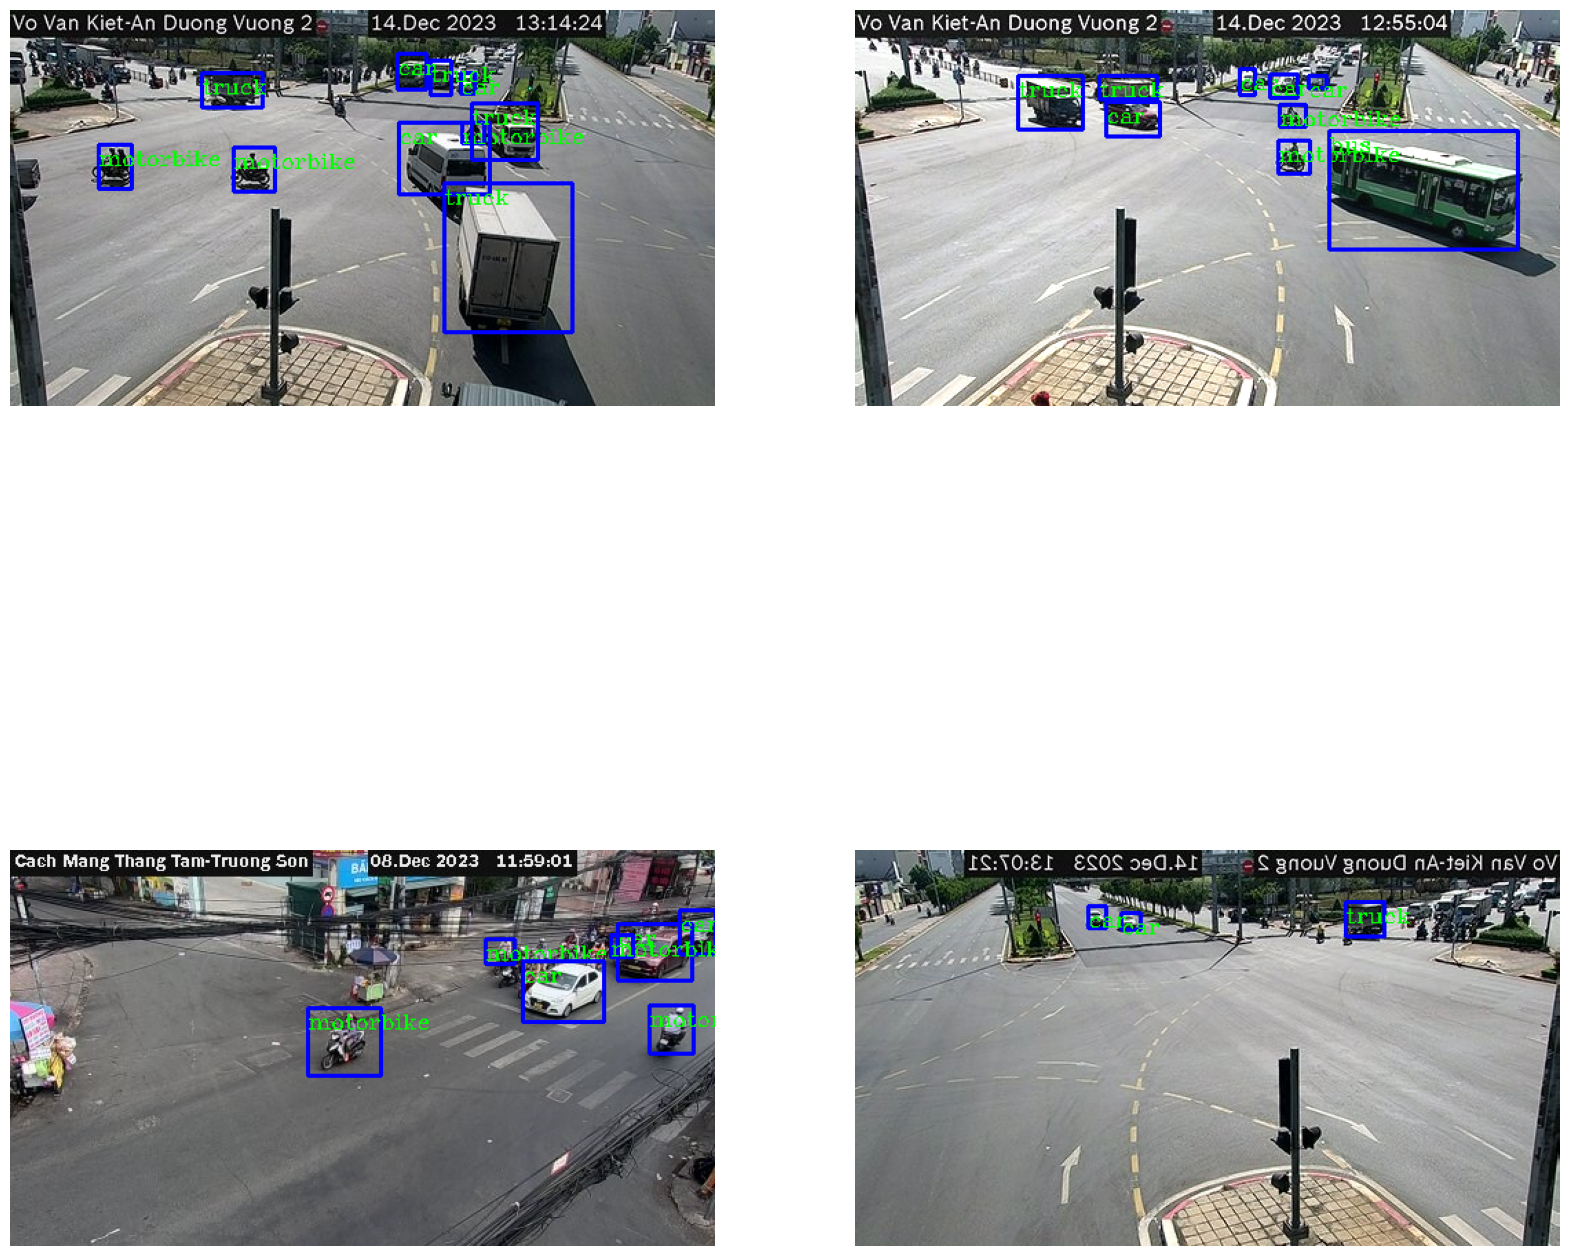

In [19]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)




In [25]:
# tải một mô hình; được đào tạo trước về COCO ##
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
num_classes = 10

# lấy số lượng đặc trưng đầu vào cho bộ phân loại
in_features = model.roi_heads.box_predictor.cls_score.in_features

# thay thế đầu đã được huấn luyện trước bằng đầu mới
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [27]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#pip install --upgrade torchvision

In [ ]:
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
#!git clone https://github.com/pytorch/vision.git
#!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

In [28]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
# huấn luyện trong 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # in sau mỗi 10 lần lặp
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # cập nhật tốc độ học tập
    lr_scheduler.step()

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn.pth')

In [ ]:
# tải một mô hình; được đào tạo trước về COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "/content/faster_rcnn.pth"

num_classes = 10

# lấy số lượng đặc trưng đầu vào cho bộ phân loại
in_features = model.roi_heads.box_predictor.cls_score.in_features

# thay thế đầu đã được huấn luyện trước bằng đầu mới
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Tải trọng lượng đã huấn luyện
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [35]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)

    model.eval()

    detection_threshold = 0.70

    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()

    return names, boxes, sample


In [ ]:
pred_path = "/content/data-img"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result
